# S0. Preprocessing expression data

This tutorial mirrors [Tutorial 01](./01-Preprocess-Expression), but uses [Seurat](https://satijalab.org/seurat/index.html) for the processing pipeline insteaed of [SingleCellExperiment](https://doi.org/doi:10.18129/B9.bioc.SingleCellExperiment).

We will demonstrate how to pre-process single-cell raw UMI counts to generate expression matrices that can be used as input to cell-cell communication tools. We recommend the [quality control](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html) chapter in the Single-cell Best Practices book as a starting point for a detailed overview of QC and single-cell RNAseq analysis pipelines in general.

We demonstrate a typical workflow using the popular single-cell analysis [Seurat](https://satijalab.org/seurat/index.html). We will use a [BALF COVID dataset](https://doi.org/10.1038/s41591-020-0901-9), which contains 12 samples associated with "Healthy Control", "Moderate", or "Severe" COVID contexts.

Details and caveats regarding [batch correction](https://www.nature.com/articles/s41592-018-0254-1), which removes technical variation while preserving biological variation between samples, can be viewed in the [Batch Correction Supplementary Tutorial](./S1_Batch_Correction.ipynb).

In [1]:
library(Seurat, quietly = TRUE)
library(ggplot2, quietly = TRUE)

options(timeout=600)

# paths
data.path <- '..//..//data/'

Attaching SeuratObject

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode



#### Loading

The 12 samples can be downloaded as .h5 files from [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE145926). You can also download the cell metadata from [here](https://raw.githubusercontent.com/zhangzlab/covid_balf/master/all.cell.annotation.meta.txt)

Alternatively, the Seurat Object can be downloaded using this [link](https://zenodo.org/record/7706962/files/BALF-COVID19-Liao_et_al-NatMed-2020.rds). See [this notebook](./build_R_objects.ipynb) for how the object was built using the above files. 

In [2]:
covid_data <- readRDS(url('https://zenodo.org/record/7706962/files/BALF-COVID19-Liao_et_al-NatMed-2020.rds'))

#### Basic Filtering

Exclude cells that visually do not fall within the normal range of standard QC metrics (see [chapter](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html)) -- fraction of genes in a cell that are mitochondrial, number of unique genes, and total number of genes measured. 

In [3]:
covid_data <- CreateSeuratObject(counts = covid_data@assays$RNA@counts, meta.data = covid_data@meta.data, 
                               min.cells = 3, min.features = 200, project = "balf.covid")

In [4]:
covid_data[["percent.mt"]] <- PercentageFeatureSet(covid_data, pattern = "^MT-")

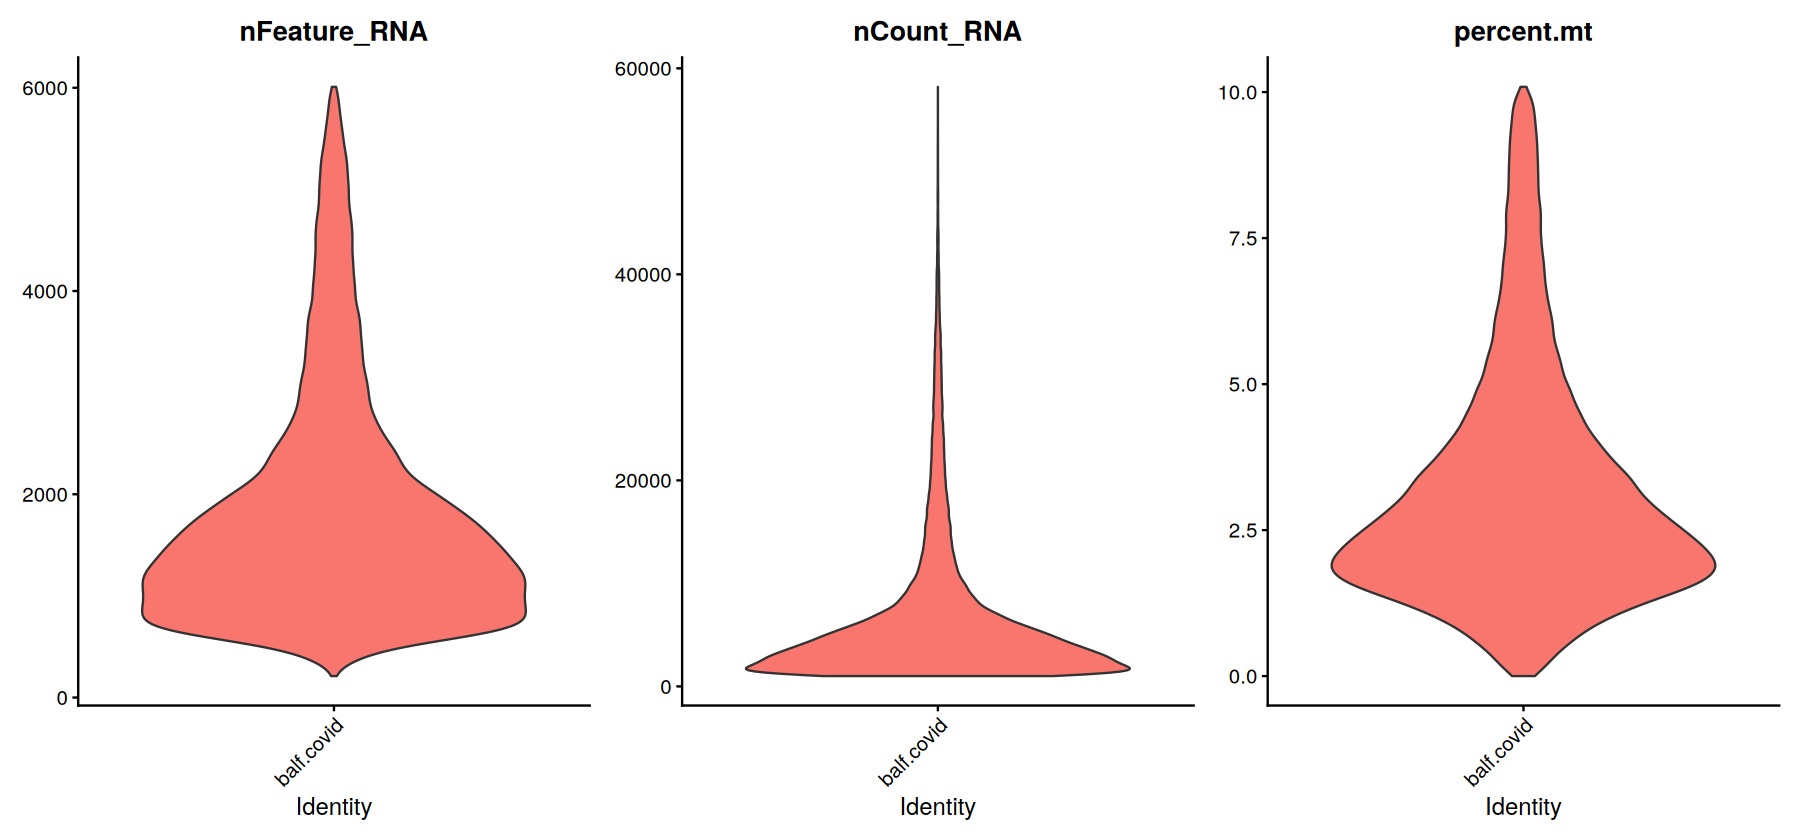

In [5]:
h_ = 7
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)
VlnPlot(covid_data, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, pt.size = 0)

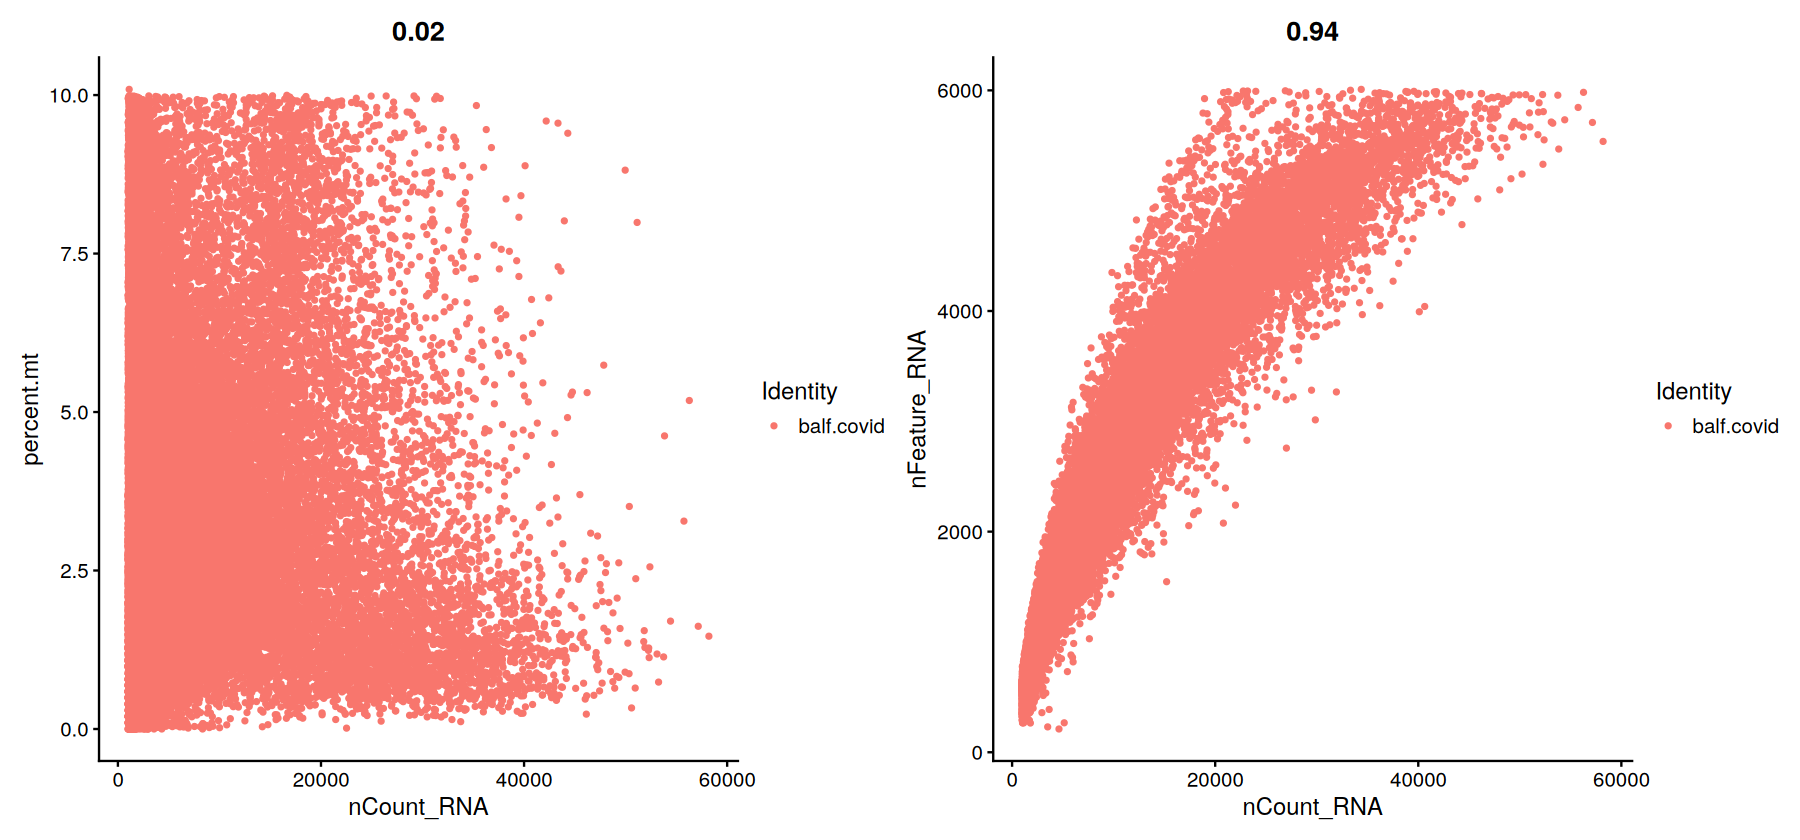

In [6]:
plot1 <- FeatureScatter(covid_data, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(covid_data, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [7]:
covid_data <- subset(covid_data, subset = nFeature_RNA < 5500) # This can be replaced by doublet detection
covid_data <- subset(covid_data, subset = percent.mt < 15)

In [8]:
covid_data

An object of class Seurat 
24798 features across 62552 samples within 1 assay 
Active assay: RNA (24798 features, 0 variable features)
 2 layers present: counts, data

#### Normalize

For single-cell inference across sample and across cell types, most CCC tools require the library sizes to be comparable. We can use the scanpy function `sc.pp.normalize_total` to normalize the library sizes. This function divides each cell by the total counts per cell and multiplies by the median of the total counts per cell. Furthermore, we log1p-transform the data to make it more Gaussian-like, as this is a common assumption for the analyses downstream. Finally, such a normalization maintains non-negative counts, which is important for tensor decomposition.

In [9]:
covid_data <- NormalizeData(covid_data, normalization.method = "LogNormalize", scale.factor = 1e4)

#### Dimensionality Reduction

While dimensionality reduction is not used directly in these tutorials, a number of these steps are necessary to obtain cell group labels when processing your own data. Steps such as filtering for highly variable genes (HVGs) and scaling the data improve dimensionality reudction and clustering results. However, for CCC, we recommend using the entire gene expression matrix unscaled (either raw or library- and log-normalized). Scaling introduces negative counts, which poses challenges for CCC inference or tensor decompsoition. Filtering for HVGs reduces the list of potential ligand-receptor pairs that can be tested for interactions.

This tutorial diverges with its companion tutorial in Python here due to minor algorithmic differences, but since the inputs will be the full expression matrices above, these discrepancies will not affect downstream tutorials. 

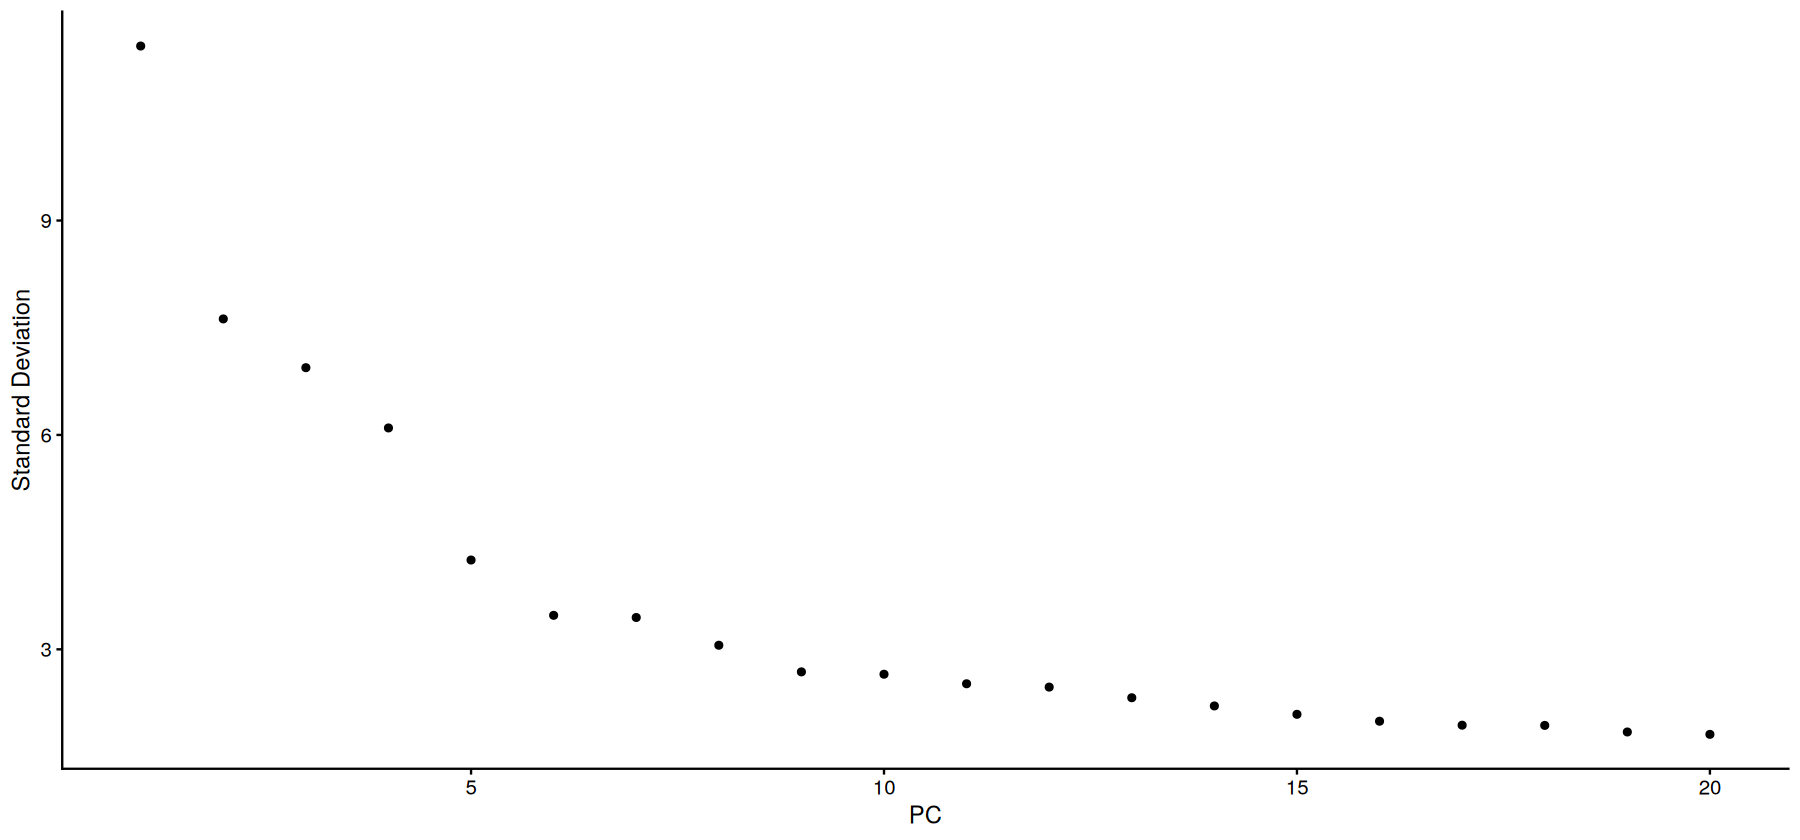

In [10]:
covid_data <- FindVariableFeatures(covid_data, selection.method = "vst", nfeatures = 2000, verbose = F) # get HVGs
all.genes <- rownames(covid_data)
covid_data <- ScaleData(covid_data, features = all.genes, verbose = F) 
covid_data <- RunPCA(covid_data, features = VariableFeatures(object = covid_data), verbose = F) 

ElbowPlot(covid_data) # visualize PCA variance explained

In [11]:
n.pcs<-20
covid_data <- FindNeighbors(covid_data, dims = 1:n.pcs, verbose = F)
covid_data <- RunUMAP(covid_data, dims = 1:n.pcs, verbose = F)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


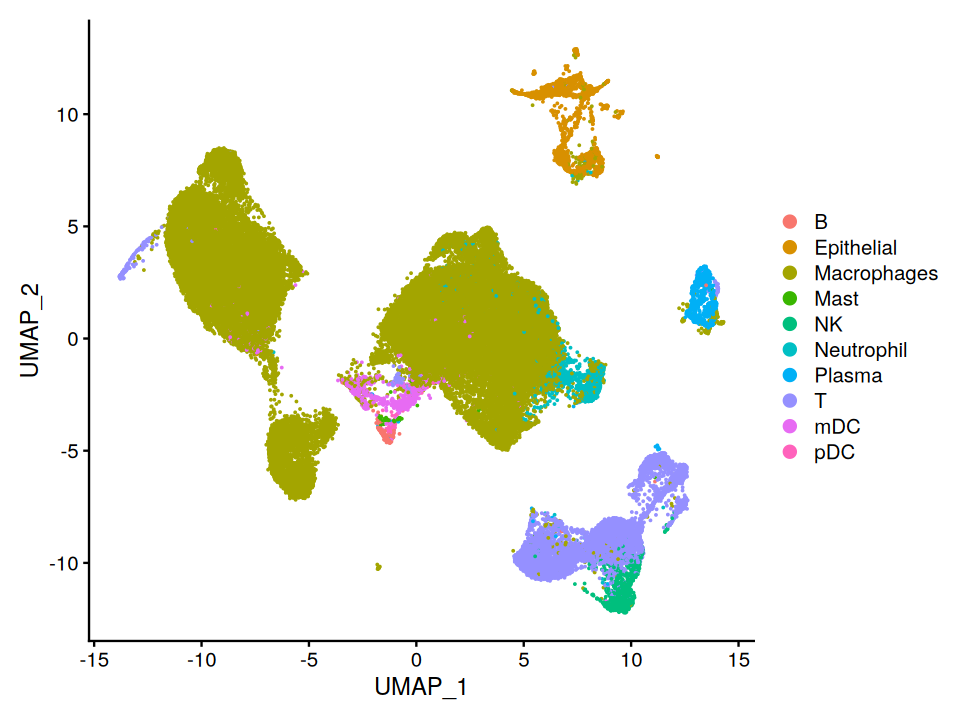

In [12]:
h_ = 6
w_ = 8
options(repr.plot.height=h_, repr.plot.width=w_)

Idents(covid_data)<-'celltype'
DimPlot(covid_data, reduction = "umap")

In [13]:
saveRDS(covid_data, file.path(data.path, 'covid_balf_norm_seurat.rds'))